In [15]:
#基于多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [16]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0810],
         [-1.0522]]),
 tensor([[ 1.0000e+00, -8.0963e-02,  3.2775e-03, -8.8451e-05,  1.7903e-06,
          -2.8990e-08,  3.9118e-10, -4.5244e-12,  4.5789e-14, -4.1191e-16,
           3.3349e-18, -2.4546e-20,  1.6561e-22, -1.0314e-24,  5.9646e-27,
          -3.2194e-29,  1.6291e-31, -7.7584e-34,  3.4897e-36, -1.4870e-38],
         [ 1.0000e+00, -1.0522e+00,  5.5360e-01, -1.9417e-01,  5.1079e-02,
          -1.0749e-02,  1.8852e-03, -2.8338e-04,  3.7273e-05, -4.3577e-06,
           4.5854e-07, -4.3863e-08,  3.8462e-09, -3.1131e-10,  2.3398e-11,
          -1.6414e-12,  1.0794e-13, -6.6813e-15,  3.9058e-16, -2.1630e-17]]),
 tensor([4.8073, 0.7259]))

In [3]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [4]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0210304  1.1914697 -3.4264941  5.590752 ]]


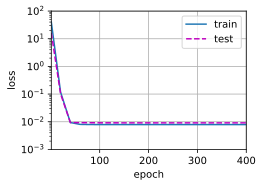

In [5]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
#正常拟合
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.6351216 6.9636793]]


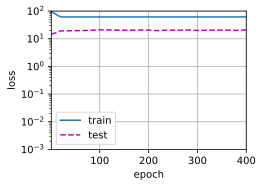

In [6]:
# 从多项式特征中选择前2个维度，即1和x
#欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.981679    1.2853215  -3.329978    5.2719026  -0.21181451  0.43888944
   0.14907245 -0.08638336  0.13670005 -0.08145335  0.20605643  0.14745589
  -0.21312085 -0.20909879  0.10001164 -0.10574807 -0.14695431  0.08165617
   0.21842182  0.18007469]]


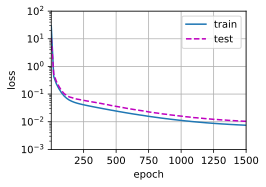

In [17]:
# 从多项式特征中选取所有维度
#过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)